In [2]:
import cv2
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from zipfile import ZipFile

%matplotlib inline

In [3]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [4]:
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)   

In [5]:
# read reference image
refFilename = "form.jpg"
print("reading image to align:", refFilename)
im1 = cv2.imread(refFilename, 1)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# read image to be aligned
imFilename = "scanned-form.jpg"
print("reading image to align", imFilename)
im2 = cv2.imread(imFilename, 1)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

reading image to align: form.jpg
reading image to align scanned-form.jpg


Text(0.5, 1.0, 'scanned form')

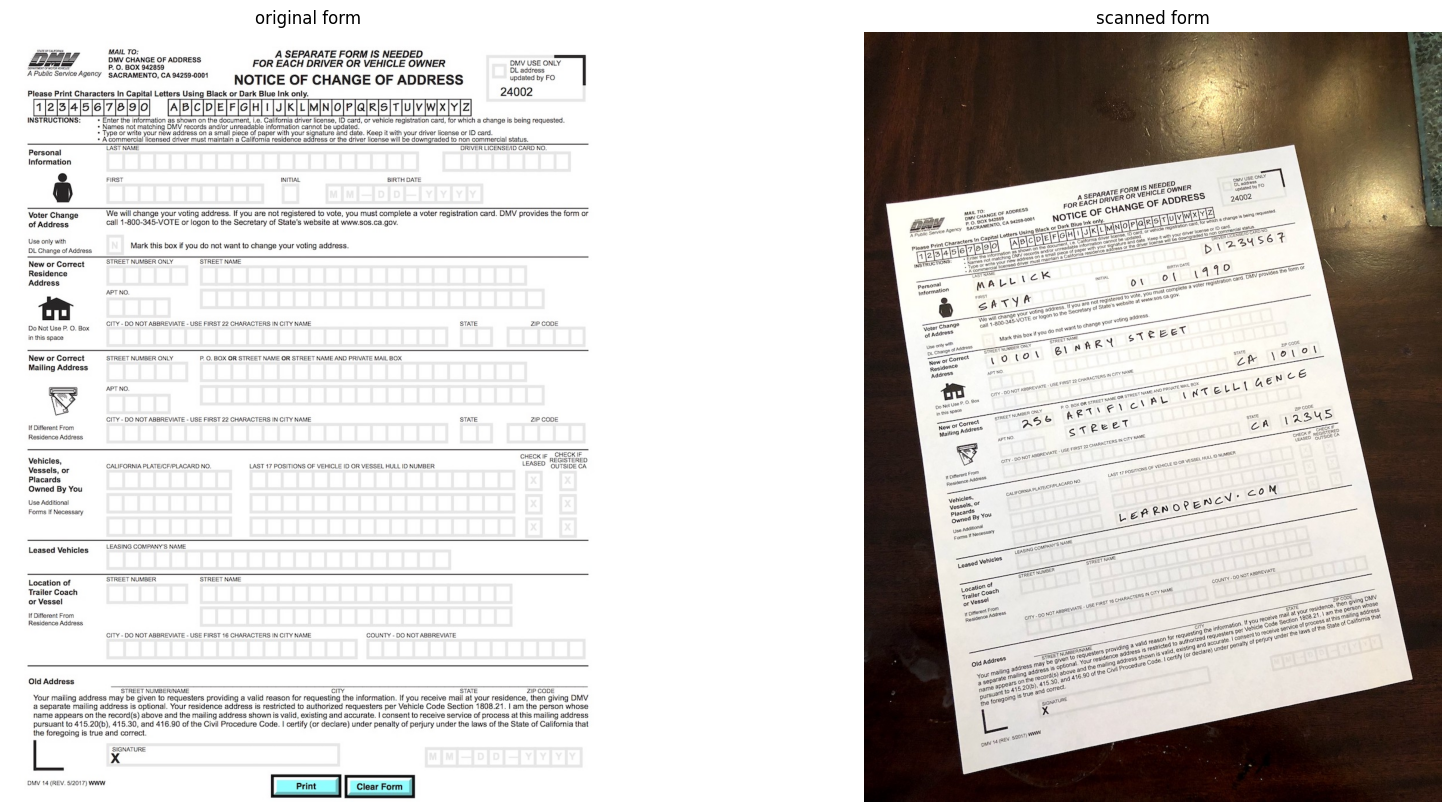

In [6]:
# display images

plt.figure(figsize=[20,10])
plt.subplot(121);plt.imshow(im1);plt.axis('off');plt.title("original form")
plt.subplot(122);plt.imshow(im2);plt.axis('off');plt.title("scanned form")

In [10]:
# convert images to grey
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)


# detect ORB features and compute descriptors,
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# display 
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]),
                                color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                                
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]),
                                color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


Text(0.5, 1.0, 'scanned form')

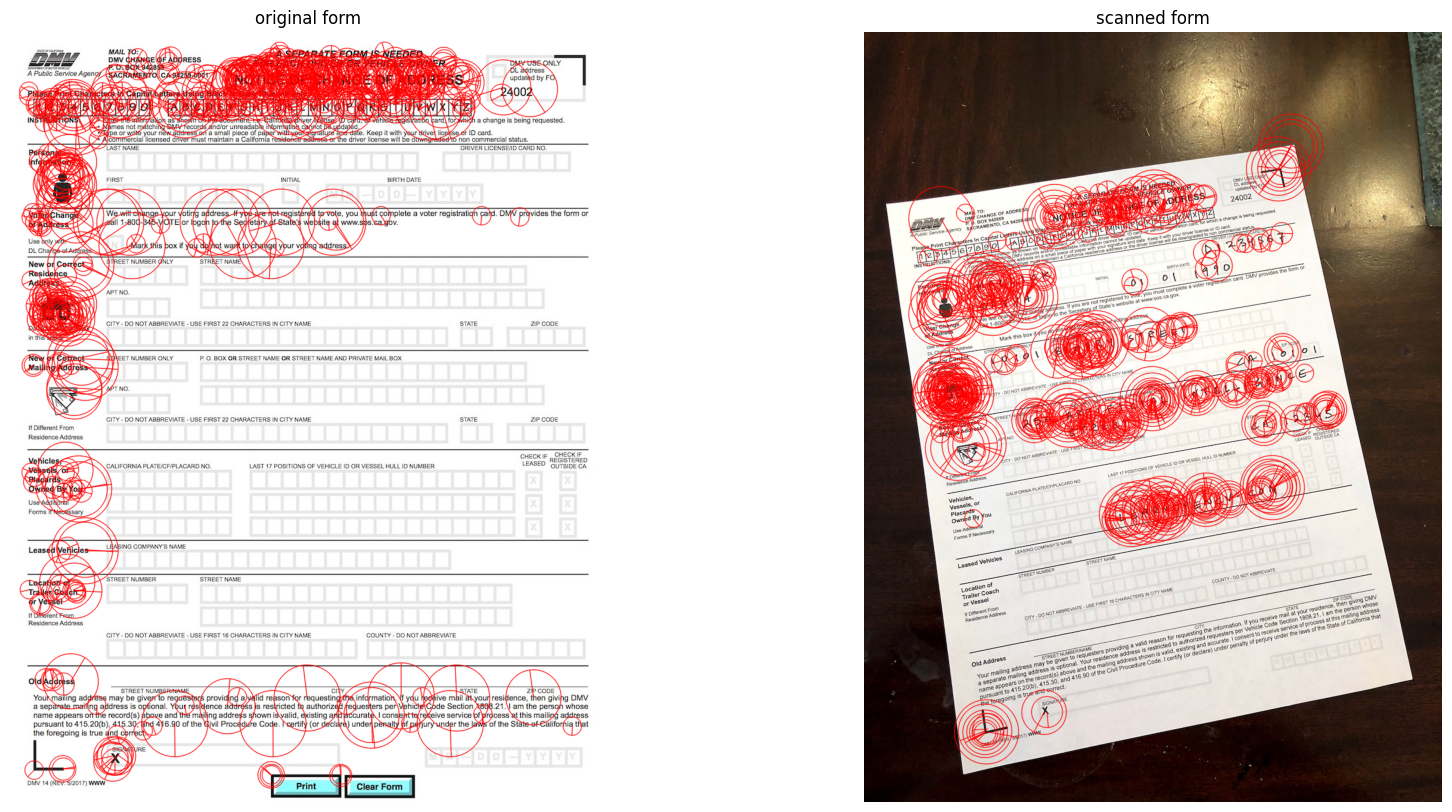

In [11]:
plt.figure(figsize=[20,10])
plt.subplot(121);plt.imshow(im1_display);plt.axis('off');plt.title("original form")
plt.subplot(122);plt.imshow(im2_display);plt.axis('off');plt.title("scanned form")

In [13]:
# match features
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# convert to list for sorting as tuples are immutable objects
matches = list (matcher.match(descriptors1, descriptors2, None))

# sort matches by score
matches.sort(key=lambda x:x.distance, reverse=False)

# remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

Text(0.5, 1.0, 'original form')

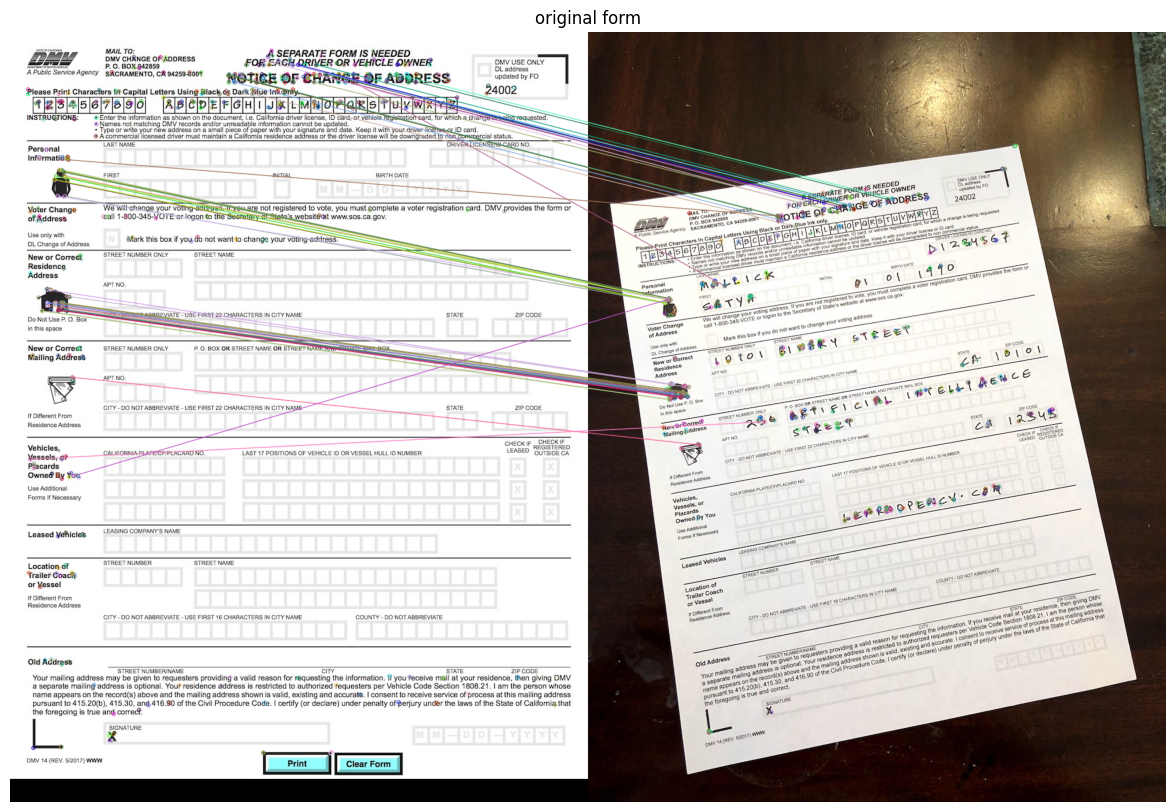

In [15]:
# draw top matches
im_matches = cv2.drawMatches(im1, keypoints1,im2, keypoints2, matches, None)

plt.figure(figsize=[40,10])
plt.imshow(im_matches);plt.axis('off');plt.title("original form")


In [20]:
# extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
    
# find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

Text(0.5, 1.0, 'Scanned Form')

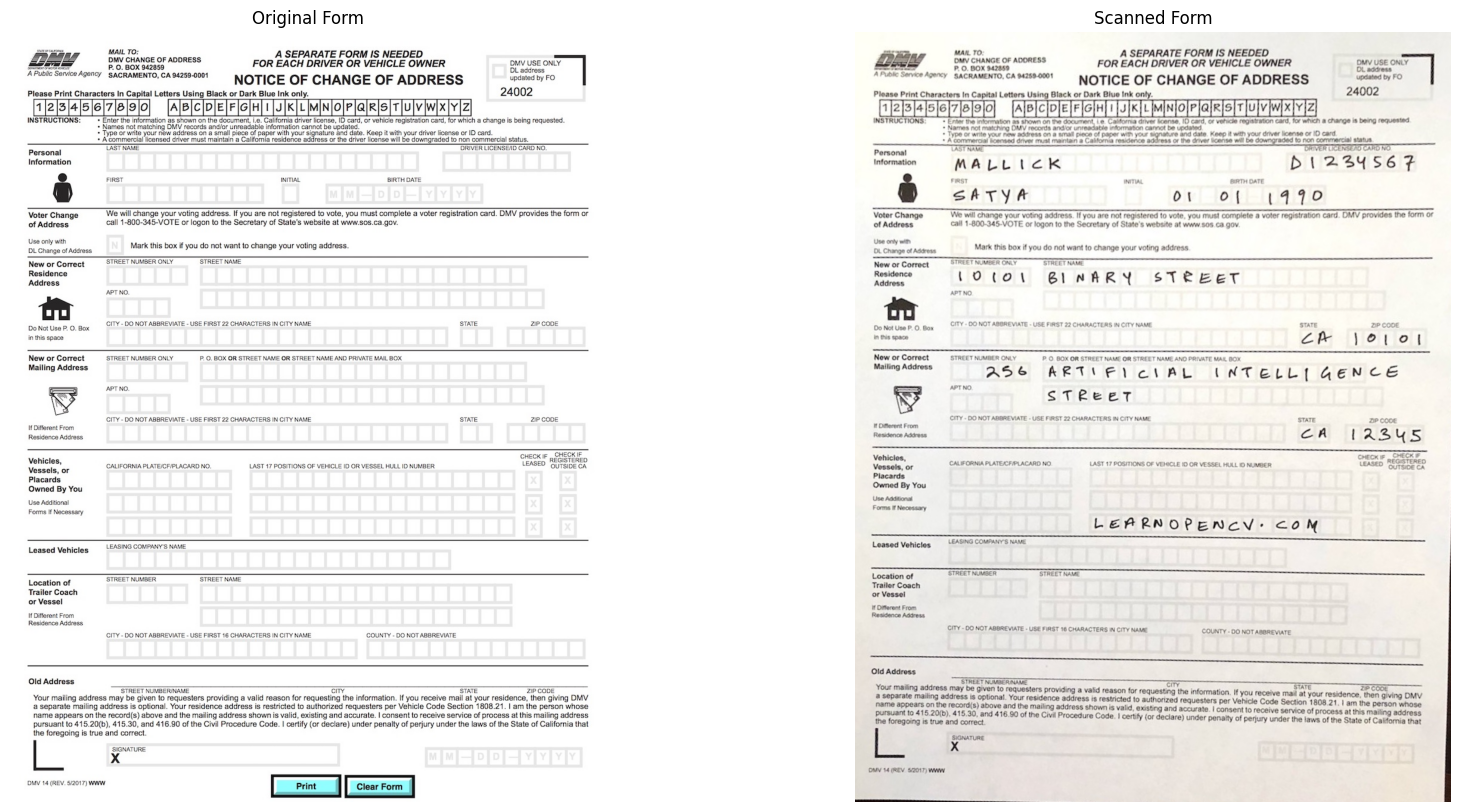

In [21]:
# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(im1);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")